In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [4]:
import jax
import jax.numpy as jnp
from jax.experimental import optimizers
from functools import partial

In [5]:
import jax_unirep
from jax_unirep.layers import AAEmbedding, mLSTM, mLSTMAvgHidden
from jax_unirep.utils import load_params, load_embedding, seq_to_oh
from jax_unirep.utils import *
from jax_unirep import get_reps

In [22]:
def differentiable_jax_unirep(ohc_seq):
    emb_params = load_embedding()
    seq_embedding = jnp.stack([jnp.matmul(ohc_seq, emb_params)], axis=0)
    _, mLSTM_apply_fun = mLSTM(1900)
    weight_params = load_params()[1]
    h_final, _, outputs = jax.vmap(partial(mLSTM_apply_fun, weight_params))(seq_embedding)
    h_avg = jnp.mean(outputs, axis=1)
    return h_avg

def index_trans(oh, alphabet, alphabet_unirep):
    matrix = jnp.zeros((len(alphabet), 26))
    for idx, aa in enumerate(alphabet):
        matrix = jax.ops.index_update(matrix, tuple([idx, alphabet_unirep.index(aa)]), 1.)
    start_char = jnp.zeros((1, 26))
    start_char = jax.ops.index_update(start_char, (0, 24), 1.)
    oh_unirep = jnp.einsum('ij,jk->ik', oh, matrix)
    oh_unirep = jnp.vstack((start_char, oh_unirep))
    return oh_unirep

In [23]:
@jax.partial(jax.custom_jvp, nondiff_argnums=(0,))
def disc_ss(key, logits):
    key, sub_key = jax.random.split(key, num=2)
    sampled_onehot = jax.nn.one_hot(jax.random.categorical(key, logits), logits.shape[-1])
    return sampled_onehot

# customized gradient for back propagation
@disc_ss.defjvp
def disc_ss_jvp(key, primals, tangents):
    key, subkey = jax.random.split(key, num=2)
    logits = primals[0]
    logits_dot = tangents[0]
    primal_out = disc_ss(key, logits)
    _, tangent_out = jax.jvp(jax.nn.softmax, primals, tangents)
    return primal_out, tangent_out

In [24]:
def norm_layer(logits, r, b):
    epsilon = 1e-5
    M, N = jnp.shape(logits)
    miu = jnp.sum(logits) / (M*N)
    std = jnp.sqrt(jnp.sum((logits - miu)**2) / (M*N))
    norm_logits = (logits - miu) / (std**2 + epsilon)
    scaled_logits = norm_logits * r + b
    return scaled_logits

def forward_seqprop(key, logits, r, b):
# normalization layer
    norm_logits = norm_layer(logits, r, b) # same dimension as logits
    # sampling layer
    sampled_vec = disc_ss(key, norm_logits)
    #sampled_vec_unirep = index_trans(sampled_vec, ALPHABET, ALPHABET_Unirep)
    return sampled_vec, norm_logits

def backward_seqprop(key, sampled_vec, norm_logits, r):
    #d_loss = jax.grad(loss_func, 1)(target, sampled_vec)  # chain rule for loss_func
    d_loss = jax.grad(target_loss_func)(sampled_vec)
    #print(d_loss)
    d_disc_ss = jax.jacfwd(disc_ss, 1)(key, norm_logits)  # chain rule for discrete sampler, should return a matrix with same dimension of logits
    #print(d_disc_ss)
    logits_grad = jnp.sum(jnp.einsum('ik,ijik->ijk', d_loss, d_disc_ss), axis=-1) * r  # equantion in seqprop paper, gradient for logits
    #print(logits_grad)
    r_grad = jnp.sum(jnp.einsum('ik,ijik,ij->ijk', d_loss, d_disc_ss, norm_logits))  # equation in seqprop paper, gradient for r (normalization layer)
    b_grad = jnp.sum(jnp.einsum('ik,ijik->ijk', d_loss, d_disc_ss))  # equation in seqprop paper, gradient for b (normalization layer)
    grad_values = (logits_grad, r_grad, b_grad)
    return grad_values

In [25]:

ALPHABET_Unirep = ['-','M','R','H','K','D','E','S','T','N','Q','C','U','G','P','A','V','I','F','Y','W','L','O','X','Z','B','J','start','stop']
ALPHABET = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
def vectorize(pep):
    '''Takes a string of amino acids and encodes it to an L x 20 one-hot vector,
    where L is the length of the peptide.'''
    vec = jnp.zeros((len(pep), 20))
    for i, letter in enumerate(pep):
        vec = jax.ops.index_update(vec, jax.ops.index[i, ALPHABET.index(letter)], 1.)
    return vec

def vec_to_seq(pep_vector):  # From Rainier's code
    seq = ''
    # expect a 2D numpy array (pep_length x 20), give the string it represents
    for letter in pep_vector[:int(jnp.sum(pep_vector))]:
        idx = jnp.argmax(letter)
        if letter[idx] == 0:
            break
        seq += ALPHABET[idx]
    return seq
#target_char = ['G','I','G','A','V','L','K','V','L','T','T','G','L','P','A','L','I','S','W','I','K','R','K','R','Q','Q']
target_char = ['A','R','N','D','C','Q','E','G','H','I','H','G','E','Q','C','D','C','Q','E','G','H','I','L','K','M','F']
oh_vec = vectorize(target_char)


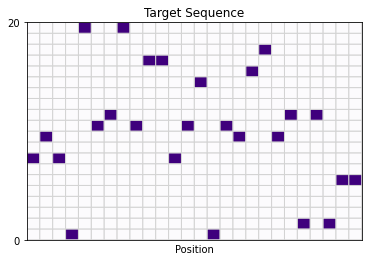

In [26]:
target_char = ['G','I','G','A','V','L','K','V','L','T','T','G','L','P','A','L','I','S','W','I','K','R','K','R','Q','Q']
oh_vec = vectorize(target_char)
plt.pcolor(jnp.transpose(oh_vec), edgecolors='lightgray', linewidths=1, cmap='Purples')
plt.yticks([0, 20])
plt.xticks([])
plt.xlabel('Position', fontsize=10)
plt.title('Target Sequence')
plt.savefig('discrete_seq.png')

In [11]:
def radio_column(jnp_list, center_idx):
    length = len(jnp_list)
    for i in range(length):
        #print((i-center_idx)**2)
        jnp_list = jax.ops.index_add(jnp_list, i, jnp.abs(i-center_idx))
    jnp_list = jax.ops.index_update(jnp_list, center_idx, 0.)
    return jnp_list

def oh_smooth(oh_vec):
    N, M = oh_vec.shape
    smooth_vec = jnp.zeros((26,20))
    scan_vec = jnp.array([i for i in range(20)])
    for i in range(N):
        center_index = int(jnp.sum(jnp.multiply(scan_vec, oh_vec[i])))
        #center_index = 0
        #print(center_index)
        smooth_vec = jax.ops.index_update(smooth_vec, i, radio_column(smooth_vec[i], center_index))
    return smooth_vec
plt.pcolor(jnp.transpose(gaussian_filter(oh_smooth(oh_vec), sigma=0.7)), edgecolors='w', linewidths=1.5, cmap='pink')
plt.yticks([0, 20])
plt.xticks([])
plt.xlabel('Position', fontsize=10)
plt.title('Smoothed Target Sequence')
plt.savefig('discrete_Gaussian_target_seq.png')

NameError: name 'gaussian_filter' is not defined

In [27]:
def target_loss_func(sampled_vec):
    def radio_column(jnp_list, center_idx):
        length = len(jnp_list)
        for i in range(length):
            #print((i-center_idx)**2)
            jnp_list = jax.ops.index_add(jnp_list, i, jnp.abs(i-center_idx))
        jnp_list = jax.ops.index_update(jnp_list, center_idx, 0.)
        return jnp_list
    #target_char = ['A','R','N','D','C','Q','E','G','H','I','H','G','E','Q','C','D','C','Q','E','G','H','I','L','K','M','F']
    
    target_char = ['G','I','G','A','V','L','K','V','L','T','T','G','L','P','A','L','I','S','W','I','K','R','K','R','Q','Q']
    oh_vec = vectorize(target_char)
    N, M = oh_vec.shape
    smooth_vec = jnp.zeros((26,20))
    scan_vec = jnp.array([i for i in range(20)])
    for i in range(N):
        center_index = int(jnp.sum(jnp.multiply(scan_vec, oh_vec[i])))
        #center_index = 0
        #print(center_index)
        smooth_vec = jax.ops.index_update(smooth_vec, i, radio_column(smooth_vec[i], center_index))
    #smooth_vec = gaussian_filter(smooth_vec, sigma=0.7)
    #print(smooth_vec)
    return jnp.sum(jnp.multiply(sampled_vec, smooth_vec))

def loss_func(target_rep, sampled_vec):
    sampled_vec_unirep = index_trans(sampled_vec, ALPHABET, ALPHABET_Unirep)
    h_avg= differentiable_jax_unirep(sampled_vec_unirep)
    # loss = jnp.mean(((target_rep - h_avg)/target_rep)**2)   # mean square error
    loss = 1-jnp.sum(jnp.vdot(h_avg, target_rep))/jnp.sqrt(jnp.sum(h_avg**2)*jnp.sum(target_rep**2))
    return loss

In [57]:
def g_loss_func(key, logits, r, b, target_rep):
    sampled_vec, _ = forward_seqprop(key, logits, r, b)
    return loss_func(target_rep, sampled_vec)

def train_seqprop_adam(key, target_rep, init_logits, init_r, init_b, iter_num=50):
    opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2, b1=0.8, b2=0.9, eps=1e-5)
    #opt_init, opt_update, get_params = optimizers.adagrad(step_size=1e-2)
    opt_state = opt_init((init_logits, init_r, init_b)) # initial state
    logits_trace = []
    loss_trace = []

    @jax.jit
    def step(key, i, opt_state):
        key, subkey = jax.random.split(key, num=2)
        p = get_params(opt_state)
        logits, r, b = p
        
        sampled_vec, norm_logits = forward_seqprop(key, logits, r, b)
        loss = loss_func(target_rep, sampled_vec)
        g = jax.grad(g_loss_func, (1,2,3))(key, logits, r, b, target_rep)
        return opt_update(i, g, opt_state), loss

    for step_idx in range(iter_num):
        #print(step_idx)
        opt_state, loss = step(key, step_idx, opt_state)
        #print(loss)
        loss_trace.append(loss)
        mid_logits, mid_r, mid_b = get_params(opt_state)
        logits_trace.append(mid_logits)
    final_logits, final_r, final_b = get_params(opt_state)
    sampled_vec, _ = forward_seqprop(key, final_logits, final_r, final_b)
    return sampled_vec, final_logits, logits_trace, loss_trace

b_train_seqprop = jax.vmap(train_seqprop_adam, (0,None,0,None,None), (0, 0, 0, 0))

In [61]:
target_char = ['G','I','G','A','V','L','K','V','L','T','T','G','L','P','A','L','I','S','W','I','K','R','K','R','Q','Q']
oh_vec = vectorize(target_char)
target_seq = ['GIGAVLKVLTTGLPALISWIKRKRQQ']
target_rep = get_reps(target_seq)[0]
key = jax.random.PRNGKey(0)
key, logits_key, r_key, b_key = jax.random.split(key, num=4)


batch_size = 64
logits = jax.random.normal(logits_key, shape=(batch_size,*jnp.shape(oh_vec)))
batch_keys = jax.random.split(key, num=batch_size)
r = jax.random.normal(r_key)
b = jax.random.normal(b_key)
sampled_vec, final_logits, logits_trace, loss_trace = b_train_seqprop(batch_keys, target_rep, logits, r, b)
#sampled_vec= train_seqprop_adam(key, target_rep, logits, r, b, iter_num = 1000)
#print(vec_to_seq(sampled_vec))


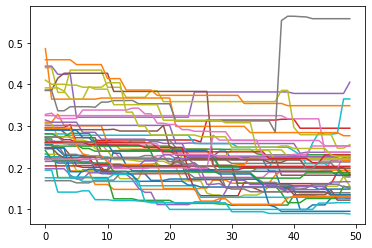

In [62]:
training_steps = 50
jax_loss_trace = jnp.array(loss_trace)
for i in range(training_steps):
    plt.plot(jax_loss_trace[:,i])

In [73]:
def beam_search(sampled_vec, final_logits, logits_trace, loss_trace, beam_num=5):
    indices = jnp.argsort(loss_trace[-1])[:beam_num]
    beam_loss = jnp.take(loss_trace[-1], indices)
    beam_seqs = []
    for idx in indices:
        beam_seqs.append(vec_to_seq(sampled_vec[idx]))
    return beam_loss, beam_seqs

In [76]:

print('GIGAVLKVLTTGLPALISWIKRKRQQ')
beam_search(sampled_vec, final_logits, logits_trace, loss_trace)[-1]

GIGAVLKVLTTGLPALISWIKRKRQQ


['KFGMYWVKFIVYVVFGKMFHLVVHFA',
 'VADSNGLFLRASMSLGVELAFMGCFK',
 'VADFIWAVILIPWEIFRRMIHTEIPK',
 'IAMTLLPWVMFHVSSWYQWMIYHATG',
 'YMYSWQPSGCIEGWVACRFISPALQL']

In [40]:
print(loss_trace)
for vec in sampled_vec:
    print(vec_to_seq(vec))
print('GIGAVLKVLTTGLPALISWIKRKRQQ')

[DeviceArray([0.17757368, 0.22656578, 0.29174387, 0.32082903, 0.39711124,
             0.2848611 , 0.33340794, 0.22231257, 0.23896056, 0.16665095,
             0.27589583, 0.19452286, 0.23511994, 0.3403163 , 0.29522395,
             0.31482762], dtype=float32), DeviceArray([0.17757368, 0.22656578, 0.24595773, 0.32082903, 0.39711124,
             0.2848611 , 0.331061  , 0.22231257, 0.23896056, 0.16797799,
             0.27589583, 0.19452286, 0.23511994, 0.33139807, 0.29522395,
             0.29780048], dtype=float32), DeviceArray([0.17757368, 0.22656578, 0.24595773, 0.32082903, 0.39711124,
             0.2848611 , 0.331061  , 0.22231257, 0.23320377, 0.16797799,
             0.20761496, 0.19452286, 0.23511994, 0.33139807, 0.29522395,
             0.29780048], dtype=float32), DeviceArray([0.17358714, 0.22656578, 0.24595773, 0.32082903, 0.39711124,
             0.2848611 , 0.331061  , 0.22231257, 0.23320377, 0.16797799,
             0.22326297, 0.19452286, 0.23511994, 0.33139807, 0.2740222

In [14]:
target_char = ['G','I','G','A','V','L','K','V','L','T','T','G','L','P','A','L','I','S','W','I','K','R','K','R','Q','Q']
oh_vec = vectorize(target_char)
target_seq = ['GIGAVLKVLTTGLPALISWIKRKRQQ']
target_rep = get_reps(target_seq)[0]
key = jax.random.PRNGKey(0)
key, logits_key, r_key, b_key = jax.random.split(key, num=4)



logits = jax.random.normal(logits_key, shape=jnp.shape(oh_vec))
r = jax.random.normal(r_key)
b = jax.random.normal(b_key)
sampled_vec, final_logits, logits_trace, loss_trace = train_seqprop_adam(key, target_rep, logits, r, b, iter_num = 600)
#sampled_vec= train_seqprop_adam(key, target_rep, logits, r, b, iter_num = 1000)
print(vec_to_seq(sampled_vec))


0
0.24398786
1
0.21973395
2
0.20381624
3
0.20381624
4
0.20381624
5
0.2128483
6
0.2128483
7
0.2128483
8
0.2128483
9
0.2128483
10
0.1653294
11
0.1653294
12
0.1653294
13
0.1653294
14
0.1653294
15
0.1653294
16
0.1653294
17
0.16596222
18
0.16596222
19
0.16596222
20
0.16596222
21
0.17832053
22
0.17832053
23
0.17832053
24
0.17832053
25
0.1262145
26
0.1262145
27
0.1262145
28
0.1262145
29
0.1262145
30
0.1262145
31
0.1262145
32
0.1262145
33
0.1262145
34
0.1262145
35
0.1262145
36
0.1262145
37
0.1262145
38
0.1262145
39
0.1262145
40
0.09899616
41
0.09899616
42
0.09899616
43
0.111288905
44
0.102678
45
0.117651165
46
0.10715258
47
0.10715258
48
0.10715258
49
0.10715258
50
0.10715258
51
0.10223669
52
0.10223669
53
0.10223669
54
0.112737596
55
0.1176976
56
0.121159256
57
0.121159256
58
0.121159256
59
0.121159256
60
0.121159256
61
0.121159256
62
0.121159256
63
0.121159256
64
0.121159256
65
0.121159256
66
0.13092941
67
0.13092941
68
0.13092941
69
0.13092941
70
0.13092941
71
0.13572997
72
0.13572997
73
0.

0.098091185
554
0.098091185
555
0.098091185
556
0.098091185
557
0.098091185
558
0.098091185
559
0.098091185
560
0.098091185
561
0.098091185
562
0.098091185
563
0.098091185
564
0.094602704
565
0.094602704
566
0.094602704
567
0.091401815
568
0.091401815
569
0.092534244
570
0.092534244
571
0.092534244
572
0.092534244
573
0.092534244
574
0.098091185
575
0.098091185
576
0.098091185
577
0.098091185
578
0.086422324
579
0.086422324
580
0.086422324
581
0.086422324
582
0.086422324
583
0.086422324
584
0.08077639
585
0.08077639
586
0.08077639
587
0.08077639
588
0.07827908
589
0.07827908
590
0.07330984
591
0.07330984
592
0.06480861
593
0.060180962
594
0.060180962
595
0.060180962
596
0.060180962
597
0.060180962
598
0.060180962
599
0.060180962
GILSRINQIWMGLAMLMPLIKKWEKP


In [68]:
print(vec_to_seq(sampled_vec))
print('GIGAVLKVLTTGLPALISWIKRKRQQ')

GILSRINQIWMGLAMLMPLIKKWEKP
GIGAVLKVLTTGLPALISWIKRKRQQ


In [1]:
def train_seqprop_batch(key, target_rep, init_logits_batch, init_r_batch, init_b_batch, iter_num=2000):
    opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2, b1=0.9, b2=0.8)
    #opt_init, opt_update, get_params = optimizers.adagrad(step_size=1e-2)
    opt_state = opt_init((init_logits, init_r, init_b)) # initial state
    logits_trace = []
    loss_trace = []

    @jax.jit
    def step(key, i, opt_state):
        key, subkey = jax.random.split(key, num=2)
        p = get_params(opt_state)
        logits, r, b = p
        
        sampled_vec, norm_logits = forward_seqprop(key, logits, r, b)
        loss = loss_func(target_rep, sampled_vec)
        g = jax.grad(g_loss_func, (1,2,3))(key, logits, r, b, target_rep)
        return opt_update(i, g, opt_state), loss

    for step_idx in range(iter_num):
        print(step_idx)
        opt_state, loss = step(key, step_idx, opt_state)
        print(loss)
        loss_trace.append(loss)
        mid_logits, mid_r, mid_b = get_params(opt_state)
        logits_trace.append(mid_logits)
    final_logits, final_r, final_b = get_params(opt_state)
    sampled_vec, _ = forward_seqprop(key, final_logits, final_r, final_b)
    return sampled_vec, final_logits, logits_trace, loss_trace

b_train_seqprop_batch = jax.vmap(train_seqprop_batch, (0,None,0,None,None,None), (0, 0, 0, 0))


NameError: name 'jax' is not defined

In [ ]:
# batch the logits 32
batch_num = 32
logits_batch = []
r_batch = []
b_batch = []
# make batched logits
for _ in range(batch_num):
    key, logits_key, r_key, b_key = jax.random.split(key, num=4)
    logits_batch.append(jax.random.normal(logits_key, shape=jnp.shape(oh_vec)))
    r_batch.append(jax.random.normal(r_key))
    b_batch.append(jax.random.normal(b_key))
    sampled_vec, final_logits, logits_trace, loss_trace = train_seqprop_adam(key, target_rep, logits, r, b, iter_num = 600)
    

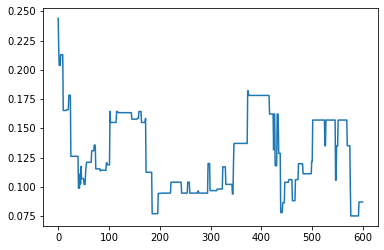

In [69]:
plt.plot(loss_trace)

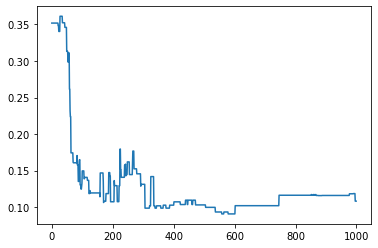

In [62]:
plt.plot(loss_trace)

In [ ]:
# beam search


In [145]:
key = jax.random.PRNGKey(37)
key, logits_key, r_key, b_key = jax.random.split(key, num=4)
logits = jax.random.normal(logits_key, shape=(26,20))
r = jax.random.normal(r_key)
b = jax.random.normal(b_key)
temp_sampled_vec, temp_final_logits, temp_logits_trace = train_seqprop_adam(key, logits, r, b, iter_num = 1000)

0
184.0
1
184.0
2
184.0
3
184.0
4
184.0
5
184.0
6
184.0
7
184.0
8
184.0
9
184.0
10
184.0
11
180.0
12
180.0
13
180.0
14
192.0
15
188.0
16
184.0
17
184.0
18
176.0
19
176.0
20
176.0
21
176.0
22
154.0
23
142.0
24
142.0
25
131.0
26
131.0
27
124.0
28
120.0
29
120.0
30
120.0
31
120.0
32
118.0
33
118.0
34
118.0
35
113.0
36
101.0
37
96.0
38
80.0
39
69.0
40
64.0
41
64.0
42
70.0
43
60.0
44
60.0
45
60.0
46
56.0
47
55.0
48
46.0
49
35.0
50
30.0
51
30.0
52
30.0
53
29.0
54
29.0
55
29.0
56
29.0
57
21.0
58
17.0
59
15.0
60
15.0
61
15.0
62
15.0
63
15.0
64
15.0
65
15.0
66
14.0
67
14.0
68
14.0
69
14.0
70
14.0
71
14.0
72
14.0
73
14.0
74
14.0
75
14.0
76
14.0
77
14.0
78
14.0
79
14.0
80
14.0
81
14.0
82
14.0
83
14.0
84
14.0
85
14.0
86
14.0
87
13.0
88
13.0
89
12.0
90
12.0
91
12.0
92
12.0
93
12.0
94
12.0
95
12.0
96
12.0
97
12.0
98
12.0
99
12.0
100
12.0
101
12.0
102
12.0
103
12.0
104
11.0
105
11.0
106
11.0
107
11.0
108
11.0
109
11.0
110
11.0
111
11.0
112
11.0
113
11.0
114
11.0
115
11.0
116
11.0
117
11.0
118
11.0
11

In [130]:
# for i in range(20):
#     key, subkey = jax.random.split(key)
#     s_vec = disc_ss(key, temp_final_logits)
#     print(vec_to_seq(s_vec))
print(temp_final_logits)
norm_layer(temp_final_logits, 1.0354831, -0.7524236)

[[  8.7347765    8.690441     7.585459     5.581587     1.218425
   -3.6504006   -6.97194     -5.833106    -7.0858593   -7.746986
   -8.045477    -9.021834    -8.733633    -6.368759   -10.610868
   -9.20209     -5.6320953   -8.49935     -8.498102    -8.946802  ]
 [  9.510634     8.881529     7.9327555    3.0952642   -2.3959672
   -4.0881877   -8.583641    -7.0253673   -5.656833    -6.1964993
   -9.014342    -7.4139214  -10.626777    -9.769233    -9.466826
  -10.564436    -9.821383    -7.896725    -8.214979    -9.141888  ]
 [  7.0782323    7.883069     8.566917     8.505351     2.2625508
   -3.977605    -4.2985325   -5.2654014   -9.448185    -6.7364445
   -7.666668    -6.7932177   -9.685458    -8.122547    -8.185707
   -7.185598    -9.436639    -8.660029    -9.316839    -7.2078094 ]
 [  8.761876     7.9071636    8.8435955    6.3698444    1.9481845
   -1.851492    -4.6870193   -5.5788994   -6.8285985   -6.671431
   -7.6460953   -7.254285    -7.8485365   -7.2828317   -8.845659
   -9.71303

DeviceArray([[-0.42989257, -0.4309852 , -0.4582173 , -0.50760233,
              -0.61513174, -0.73512304, -0.8169818 , -0.78891546,
              -0.81978935, -0.8360827 , -0.8434389 , -0.8675011 ,
              -0.8603984 , -0.8021165 , -0.9066626 , -0.8719435 ,
              -0.7839616 , -0.85462457, -0.8545938 , -0.8656519 ],
             [-0.4107717 , -0.42627588, -0.44965822, -0.56887734,
              -0.7042078 , -0.74591225, -0.8567019 , -0.8182985 ,
              -0.78457123, -0.79787123, -0.8673164 , -0.82787436,
              -0.9070546 , -0.8859206 , -0.87846786, -0.90551823,
              -0.88720584, -0.83977294, -0.8476163 , -0.8704598 ],
             [-0.4707178 , -0.45088273, -0.43402943, -0.43554673,
              -0.5893994 , -0.74318695, -0.7510961 , -0.77492446,
              -0.8780084 , -0.8111781 , -0.8341032 , -0.81257725,
              -0.88385594, -0.84533834, -0.84689486, -0.8222474 ,
              -0.8777239 , -0.85858446, -0.8747714 , -0.8227948 ],
       

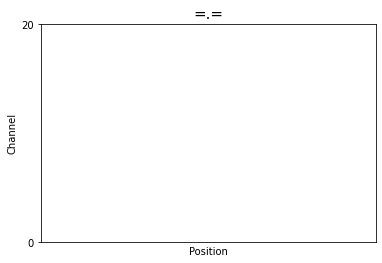

In [147]:
from celluloid import Camera
fig = plt.figure()
camera = Camera(fig)

for i in range(100):
    p = plt.pcolor(jnp.transpose(temp_logits_trace[i]), edgecolors='w', linewidths=1.5, cmap='Blues')
    plt.yticks([0, 20])
    plt.xticks([])
    plt.legend(['step %d' % (i)] , markerscale=0.1)
    plt.xlabel('Position', fontsize=10)
    plt.ylabel('Channel', fontsize=10)
    plt.title('=.=', fontsize=15)
    camera.snap()
animation = camera.animate()
animation.save('wow.gif', writer = 'imagemagick', dpi=800)

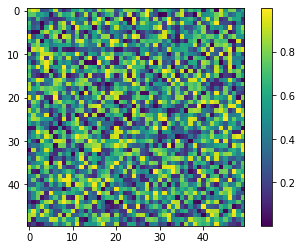

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.imshow(np.random.random((50,50)))
plt.colorbar()
plt.show()

In [75]:
def numerical_gradient(key, f, x0, N=1000, delta=10): # f is a wrapping function, x0 is the input vector/matrix for f
    g = []
    g_sum = jnp.zeros(x0.shape)
    for i in range(N):
        print(i)
        key, subkey = jax.random.split(key, num=2)
        u = jax.random.normal(key, x0.shape)
        u /= jnp.sqrt(jnp.sum(jnp.array([e**2 for e in u])))
        g.append((f(x0 + delta*u) - f(x0)) * u / delta)
        g_sum += g[i] 
    g_avg = g_sum /N
    return g_avg


In [76]:
def end2end(logits):
    key = jax.random.PRNGKey(37)
    key, logits_key, r_key, b_key = jax.random.split(key, num=4)
    #logits = jax.random.normal(logits_key, shape=(26,20))
    r = jax.random.normal(r_key)
    b = jax.random.normal(b_key)
    sampled_vec, norm_logits = forward_seqprop(key, logits, r, b)
    loss = temp_loss_func(sampled_vec)
    print(loss)
    #gradient = backward_seqprop(key, sampled_vec, norm_logits, r)

    return loss

In [77]:
logits = jax.random.normal(logits_key, shape=(26,20))
numerical_gradient(key, end2end, logits)

0
304.0
304.0
1
304.0
304.0
2
304.0
304.0
3
304.0
304.0
4
319.0
304.0
5
319.0
304.0
6
304.0
304.0
7
309.0
304.0
8
304.0
304.0
9
319.0
304.0
10
304.0
304.0
11
304.0
304.0
12
304.0
304.0
13
319.0
304.0
14
304.0
304.0
15
304.0
304.0
16
304.0
304.0
17
309.0
304.0
18
304.0
304.0
19
319.0
304.0
20
309.0
304.0
21
304.0
304.0
22
309.0
304.0
23
309.0
304.0
24
304.0
304.0
25
309.0
304.0
26
309.0
304.0
27
324.0
304.0
28
319.0
304.0
29
309.0
304.0
30
304.0
304.0
31
319.0
304.0
32
319.0
304.0
33
304.0
304.0
34
319.0
304.0
35
304.0
304.0
36
304.0
304.0
37
304.0
304.0
38
324.0
304.0
39
304.0
304.0
40
309.0
304.0
41
319.0
304.0
42
304.0
304.0
43
304.0
304.0
44
304.0
304.0
45
304.0
304.0
46
309.0
304.0
47
309.0
304.0
48
304.0
304.0
49
304.0
304.0
50
309.0
304.0
51
304.0
304.0
52
304.0
304.0
53
309.0
304.0
54
319.0
304.0
55
304.0
304.0
56
304.0
304.0
57
304.0
304.0
58
304.0
304.0
59
304.0
304.0
60
309.0
304.0
61
304.0
304.0
62
309.0
304.0
63
304.0
304.0
64
304.0
304.0
65
304.0
304.0
66
319.0
304.0
67
30

319.0
304.0
523
304.0
304.0
524
304.0
304.0
525
319.0
304.0
526
319.0
304.0
527
304.0
304.0
528
304.0
304.0
529
324.0
304.0
530
304.0
304.0
531
309.0
304.0
532
304.0
304.0
533
309.0
304.0
534
304.0
304.0
535
304.0
304.0
536
319.0
304.0
537
304.0
304.0
538
304.0
304.0
539
304.0
304.0
540
304.0
304.0
541
304.0
304.0
542
319.0
304.0
543
319.0
304.0
544
307.0
304.0
545
324.0
304.0
546
309.0
304.0
547
319.0
304.0
548
304.0
304.0
549
319.0
304.0
550
304.0
304.0
551
309.0
304.0
552
304.0
304.0
553
304.0
304.0
554
319.0
304.0
555
304.0
304.0
556
309.0
304.0
557
304.0
304.0
558
304.0
304.0
559
304.0
304.0
560
304.0
304.0
561
304.0
304.0
562
304.0
304.0
563
304.0
304.0
564
304.0
304.0
565
304.0
304.0
566
319.0
304.0
567
304.0
304.0
568
304.0
304.0
569
304.0
304.0
570
324.0
304.0
571
304.0
304.0
572
319.0
304.0
573
304.0
304.0
574
304.0
304.0
575
319.0
304.0
576
309.0
304.0
577
304.0
304.0
578
297.0
304.0
579
319.0
304.0
580
324.0
304.0
581
304.0
304.0
582
304.0
304.0
583
319.0
304.0
584
304.0
30

DeviceArray([[-1.07636000e-03, -1.21288304e-03,  1.78942760e-03,
               1.16201979e-03,  7.48048711e-04, -1.93178095e-03,
              -5.83439949e-04,  8.24052433e-04, -1.94930227e-03,
               1.09794410e-03, -1.33783766e-03,  4.87843849e-04,
               9.88825923e-04, -7.81648210e-04,  4.55914938e-04,
              -6.05748617e-04,  5.06817363e-04,  5.90324518e-04,
              -1.24305848e-03, -7.02574209e-04],
             [ 1.62087672e-04, -1.72378228e-03,  8.66915681e-04,
              -7.32134155e-04,  7.36474758e-04, -2.20546754e-05,
               4.47587954e-04, -8.17084801e-04, -7.40177929e-04,
              -7.61982985e-04,  3.03406723e-05, -1.22952595e-04,
              -1.61802920e-03,  2.43989023e-04,  5.64205344e-04,
              -2.05667666e-03, -5.41957736e-04,  1.09087513e-03,
               3.64370528e-04, -2.18859315e-03],
             [ 1.07043050e-03,  3.42881045e-04,  4.70447238e-04,
              -2.16631815e-04,  1.37578847e-03,  7.413849

In [ ]:
def forward_seqprop(key, logits, r, b)